In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')
from joblib import dump, load

# 读取数据
capacity = load('capacity')

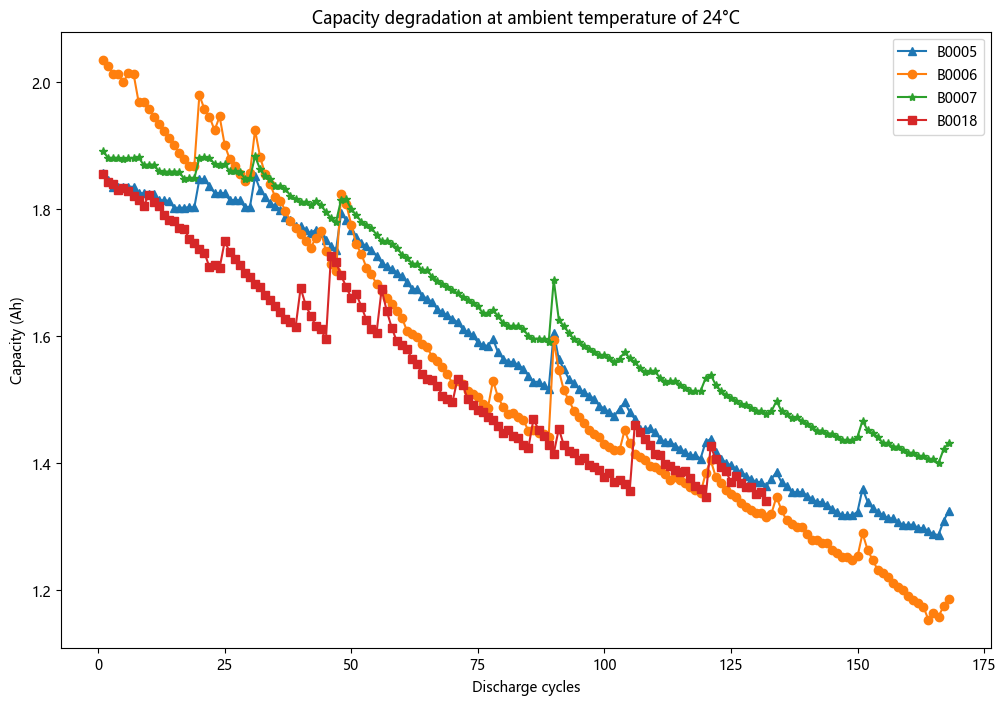

In [15]:
import matplotlib.pyplot as plt
import matplotlib

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018'] # 4 个数据集的名字
fig, ax = plt.subplots(1, figsize=(12, 8))
marker_list = ['^', 'o', '*', 's']
c = 0
for name in Battery_list:
    data = capacity[name]
    line_type = marker_list[c]
    ax.plot(data[0], data[1], marker=line_type, label=name)
    c += 1
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

In [16]:
import matplotlib.pyplot as plt
import matplotlib

for name in Battery_list:
    data = capacity[name]
    print(data[0])
    print(data[1])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168]
[1.8564874208181574, 1.846327249719927, 1.8353491942234077, 1.8352625275821128, 1.8346455082120419, 1.8356616600675495, 1.8351461429226603, 1.8257567905665537, 1.8247738529891333, 1.824613268496936, 1.8246195526864504, 1.8142019357673917, 1.8137521577549054, 1.813440

# 以 B0018 数据集为例

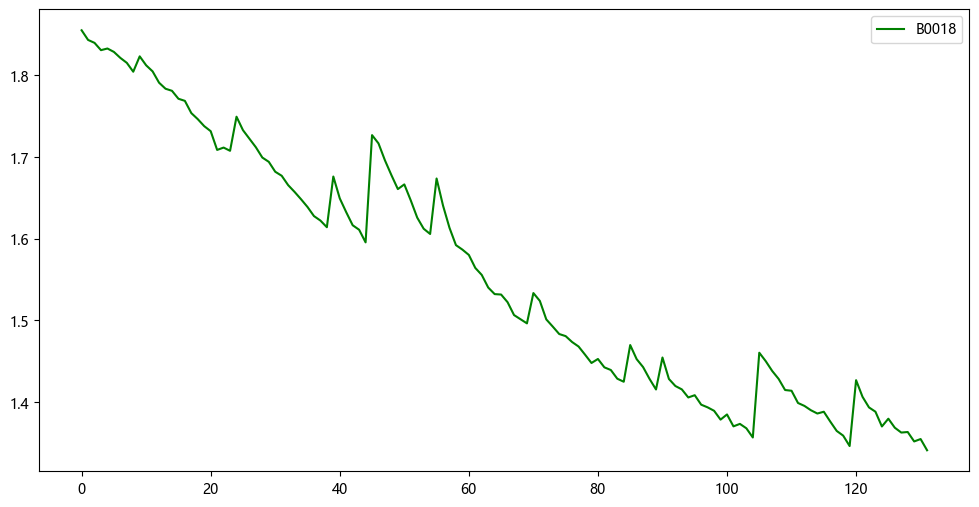

In [2]:
# 取 B0005 数据
target_data = capacity['B0018'][1]
# 可视化结果
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(target_data, label='B0018',color='green')  # 真实值
plt.legend()
plt.show()

In [3]:
# 制作数据集和标签
import torch
import numpy as np
import pandas as pd
from joblib import dump, load
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 取 B0005 数据
target_data = capacity['B0018'][1]

# 把数据进行转换，方便进行归一化
target_data = np.array(target_data) # 转换为numpy
target_data = target_data.reshape(-1, 1)

# 归一化处理
# 使用标准化（z-score标准化）
scaler = StandardScaler()
target_data = scaler.fit_transform(target_data)
# 保存 归一化 模型
dump(scaler, 'scaler') 


# 这些转换是为了将数据和标签转换为PyTorch可以处理的张量
def make_data_labels(x_data, y_label):
    '''
        返回 x_data: 数据集     torch.tensor
            y_label: 对应标签值  torch.tensor
    '''
    # 信号值
    x_data = torch.tensor(x_data).float()
    # 标签值
    y_label = torch.tensor(y_label).float()
    return x_data, y_label


# 使用滑动窗口处理时间序列数据
def data_window_maker(time_series, window_size):
    '''
        参数:
        time_series: 风速数据集(为numpy数组格式)
        window_size: 滑动窗口大小
        ndim: 数组维度

        返回:
        data_x: 特征数据
        data_y: 标签数据
    '''
    # 用来存放输入特征
    data_x = []
    # 用来存放输出标签
    data_y = []
    # 构建训练集和对应标签
    data_len = time_series.shape[0]
    for i in range(data_len - window_size):
            data_x.append(time_series[i:i+window_size, :])  # 取前window_size个数据作为输入特征
            data_y.append(time_series[i+window_size, :])  # 取第window_size+1个数据作为输出标签
    

    # 将列表转换为单一的NumPy数组
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    # 转换为 tensor
    data_x, data_y = make_data_labels(data_x, data_y)
    return data_x, data_y


# 数据集制作
def make_wind_dataset(data, window_size, split_rate = [0.7, 0.3]):
    '''
        参数:
        data: 数据集(为numpy数组格式)
        window_size: 滑动窗口大小
        split_rate: 训练集、测试集划分比例

        返回:
        train_set: 训练集数据
        train_label: 训练集标签
        test_set: 测试集数据
        test_label: 测试集标签
    '''
    # 第一步，划分数据集
    sample_len = data.shape[0] # 样本总长度
    train_len = int(sample_len*split_rate[0])  # 向下取整
    train_data = data[:train_len, :] # 训练集
    # print(len(train_data)) 
    test_data = data[train_len:, :]  # 测试集
    # print(len(test_data))  

    # 第二步，制作数据集标签  滑动窗口
    train_set, train_label = data_window_maker(train_data, window_size)
    test_set, test_label = data_window_maker(test_data, window_size)

    return train_set, train_label, test_set, test_label


# 定义滑动窗口大小
window_size = 1
# 数据集划分比例
split_rate = [0.7, 0.3]
# 制作数据集
train_set, train_label, test_set, test_label = make_wind_dataset(target_data, window_size, split_rate)
# 保存数据
dump(train_set, 'train_set') 
dump(train_label, 'train_label') 
dump(test_set, 'test_set') 
dump(test_label, 'test_label') 

['test_label']

In [4]:
print('数据 形状：')
print(train_set.size(), train_label.size())
print(test_set.size(), test_label.size())

# 变量 序列长度为 1 , 预测一个 值 （单步预测）

数据 形状：
torch.Size([91, 1, 1]) torch.Size([91, 1])
torch.Size([39, 1, 1]) torch.Size([39, 1])
